In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math

In [2]:
cities = np.loadtxt("cities.dat")
initial_path = np.loadtxt("initial_best_path.dat", skiprows=1, dtype=int)
initial_path = np.append(initial_path, 0)
best_path = np.loadtxt("path_random_search.dat", skiprows=1, dtype=int)
best_path = np.append(best_path, 0)

In [3]:
def plot_network(G):
    """Plots the network."""
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=False, node_size=10, node_color='skyblue', font_size=10, font_weight='bold', arrows=True)
    plt.show()

In [4]:
def create_graph(cities, path):
    G = nx.DiGraph()
    for n, pos in enumerate(cities):
        G.add_node(n, pos=pos)
    
    for n1, n2 in zip(path, path[1:]):
        G.add_edge(n1, n2)

    return G

In [5]:
def compute_cycle_length(G, cycle):
    """Computes the length of the cycle in the graph."""
    length = 0
    for (id1, id2) in zip(cycle, cycle[1:]):
        pos1 = G.nodes[id1]['pos']
        pos2 = G.nodes[id2]['pos']
        distance = math.sqrt((pos2[0] - pos1[0])**2 + (pos2[1] - pos1[1])**2)
        length += distance
    return length

In [6]:
initial_sol = create_graph(cities, initial_path)

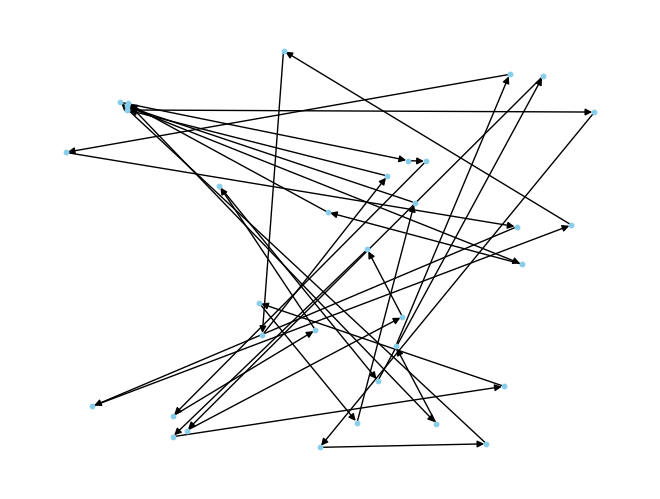

In [7]:
plot_network(initial_sol)

In [8]:
compute_cycle_length(initial_sol, initial_path)

20.846770971912157

In [9]:
best_sol = create_graph(cities, best_path)

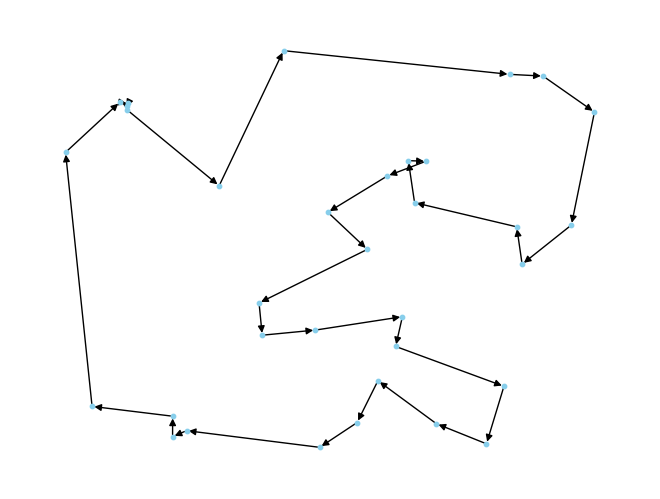

In [10]:
plot_network(best_sol)

In [11]:
compute_cycle_length(best_sol, best_path)

5.096518244552054